<a href="https://colab.research.google.com/github/androbaza/smlm-seg/blob/main/SMLM_image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%%capture
%cd /content/drive/MyDrive/ANNA-PALM
%tensorflow_version 1.x
!pip install scipy==1.2 wand magickwand
!pip install -r requirements.txt
!apt-get install libmagickwand-dev

In [36]:
import numpy as np
import cv2, skimage, os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow 
from skimage import morphology
from skimage.measure import label
from wand.image import Image

# anna-palm

In [37]:
# function for image tiling

def make_tiles(input, output_dir, img_n):
    i = 0
    with Image(filename=input) as img:
        for h in range(0, img.height, 512):
            for w in range(0, img.width, 512):
                w_end = w + 512
                if w_end > img.width:
                    w_end = img.width
                    w = img.width - 512
                h_end = h + 512
                if h_end > img.height:
                    h_end = img.height
                    h = img.height - 512
                with img[w:w_end, h:h_end] as chunk:
                    chunk.save(filename=output_dir+'A_'+str(img_n)+'_tile_{0}.png'.format(i))
                i += 1

In [ ]:
# images have to be grey, 1-layer for anna-palm input

input_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/raw_inputs'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/test/tiled/'

img_n = 0
for fname in os.listdir(input_dir):
    temp_file = os.path.join(output_dir, os.path.splitext(fname)[0])+"temp.png"
    skimage.io.imsave(temp_file, 
                    skimage.io.imread(os.path.join(input_dir, fname), as_gray=1))
    make_tiles(temp_file, output_dir, img_n)
    os.remove(temp_file)
    img_n += 1

In [ ]:
# main ANNA-PALM model execution. 
%%capture
%cd /content/drive/MyDrive/ANNA-PALM
!python run_img.py --workdir=/content/drive/MyDrive/ANNA-PALM/Microtubules --load_dir=/content/drive/MyDrive/ANNA-PALM/Microtubules/945 --phase=test

In [ ]:
# delete unneeded temp files, convert the images to binary masks
%%capture
input_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/outputs'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/masked'

for fname in os.listdir(dir):
    if fname.endswith("reco_B_b0_i0.tif"):
        img = skimage.io.imread(os.path.join(dir, fname), as_gray=1)
        # img = cv2.imread(os.path.join(dir, fname), 0)
        blur = (cv2.GaussianBlur(img,(3,3),0)*255).astype(np.uint8)
        ret, fig = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        filtered1 = morphology.erosion(morphology.dilation(labels2, morphology.square(4)), morphology.square(2))

        filtered = morphology.remove_small_objects(filtered1 > 0, 150)

        if(np.count_nonzero(fig)/fig.size < 0.001): 
            continue
        skimage.io.imsave(os.path.join(output_dir, os.path.splitext(os.path.splitext(fname)[0])[0])+"_masked.png", fig)
    else:
        os.remove(os.path.join(dir, fname))

###Visualize dataset and masks

In [ ]:
def plot_dataset(X, Y, num=5, vmin_x=0, vmax_x=255, vmax_y=2):
    """Visualize num examples from images X and labels Y"""
    fig, axes = plt.subplots(2,num, figsize=(15,6))
    for i,ax in enumerate(axes[0]):
        ax.imshow(X[i,:,:,0], cmap='gray', vmin=vmin_x, vmax=vmax_x)
        ax.axis('off')
        ax.set_title('image patch {}'.format(i))
    for i,ax in enumerate(axes[1]):
        ax.imshow(Y[i,:,:,0], vmin=0t, vmax=vmax_y)
        ax.axis('off')
        ax.set_title('label patch {}'.format(i))
    return fig

print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

# visualize image and label patches
fig = plot_dataset(X_train, Y_train)
fig.suptitle("Example train patches")

fig = plot_dataset(X_val, Y_val)
fig.suptitle("Example val patches")

# Microtubules

## morphological

In [38]:
def plot_comparison(original, filtered):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    # ax2.set_title(filter_name)
    ax2.axis('off')
    
def create_mask(img, mask_value=1):
    return img < 0

def binarize(img):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret, fig = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return fig

[[ 7  8 11 ...  0  0  0]
 [ 8  9 12 ...  0  0  0]
 [ 9 10 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


True

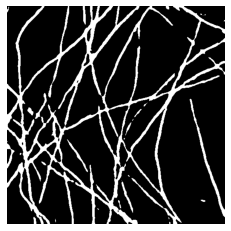

In [ ]:
# TODO: Otsu's Binarization


# img = cv2.imread('/content/drive/MyDrive/ANet2/ANNA-PALM/test_workdir_exp1/outputs2/grey_A_2.png_reco_B_b0_i0.tif', 0)
# img = opened
img = skimage.io.imread('/content/drive/MyDrive/ANet2/ANNA-PALM/test_workdir_exp1/outputs2/grey_A_2.png_reco_B_b0_i0.tif', as_gray=1)
# print(blur.shape)
# img = create_mask(img2).astype(np.uint8)
blur = (cv2.GaussianBlur(img,(7,7),0)*255).astype(np.uint8)
print(blur)
ret, fig = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(fig, cmap='gray')
# plt.savefig("1mask.png", bbox_inches='tight')
cv2.imwrite("tub-11x11-closing-disk4.png", fig)
# plt.show()

In [ ]:
element = np.array([[0,0,0],
                    [0,1,0],
                    [0,0,0]])

def multi_ero(im, num, element=element):
    for i in range(num):
        im = erosion(im, element)
    return im

def multi_dil(im, num, element=element):
    for i in range(num):
        im = dilation(im, element)
    return im

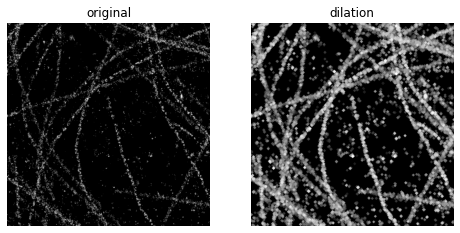

In [ ]:
multi_eroded = multi_dil(orig_phantom, 3, disk(1))
plot_comparison(orig_phantom, multi_eroded, 'dilation')

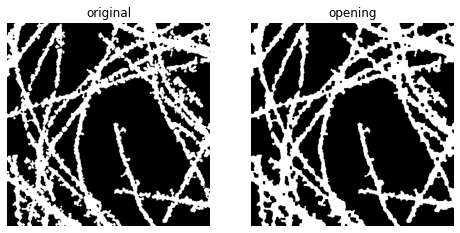

In [ ]:
import cv2

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('1.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (3,3), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

thresh = binarize(multi_eroded)

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 350:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plot_comparison(thresh, close, 'opening')

# cv2_imshow('thresh', thresh)
# cv2_imshow('close', close)
# cv2.waitKey()

In [ ]:
cv2.imwrite("tub-5x5-closing-rem-small.png", close)

True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  """Entry point for launching an IPython kernel.


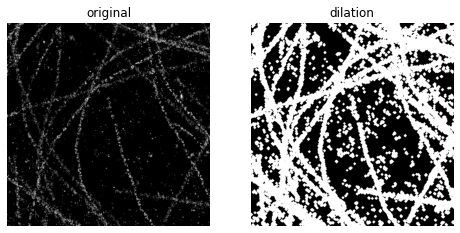

In [ ]:
rem_small = morphology.remove_small_holes(multi_eroded,1)
plot_comparison(orig_phantom, rem_small, 'dilation')

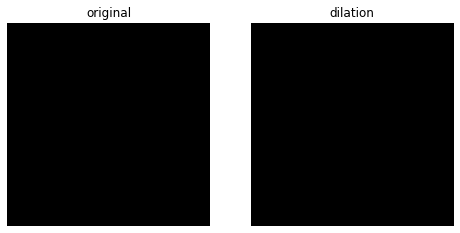

In [ ]:
bin = create_mask(closed)
rem_small = morphology.remove_small_objects(bin ,2)
plot_comparison(bin, rem_small, 'dilation')

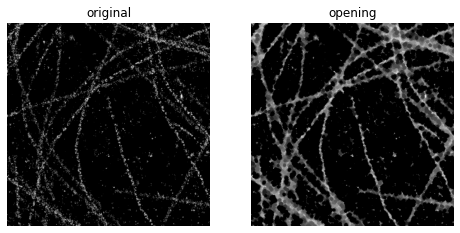

In [ ]:
closed = closing(orig_phantom, disk(4))
plot_comparison(orig_phantom, closed, 'opening')

In [ ]:
%cd /content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp

/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp


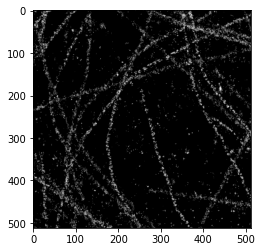

In [ ]:
import skimage
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.io import imread

im = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/test_workdir_exp1/test/12.png", as_gray=1)
orig_phantom = img_as_ubyte(im)
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

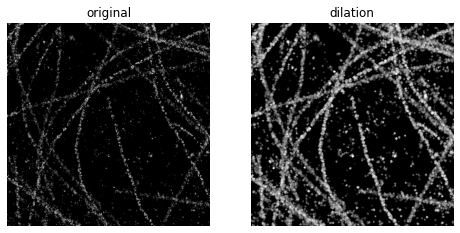

In [ ]:
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk, square  # noqa

# footprint = disk(3)
# m = square(5)
dilated = dilation(orig_phantom, disk(2))
plot_comparison(orig_phantom, dilated, 'dilation')

## Random walker segmentation

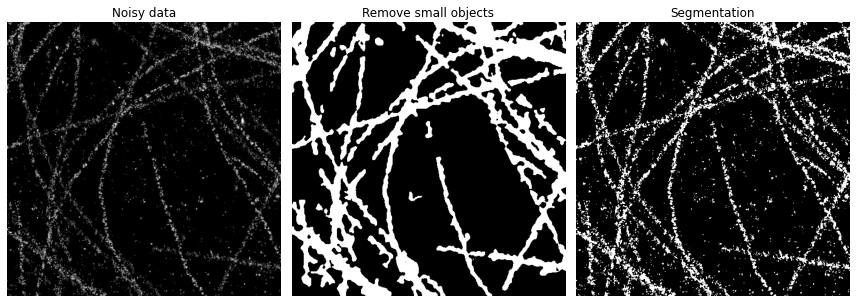

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

rng = np.random.default_rng()

img = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp/1-m.png", as_gray=1)

markers = np.zeros(data.shape, dtype=np.uint)
markers[data < 0.1] = 1
markers[data > 0.2] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')
labels2 = rescale_intensity(labels, out_range=(0, 1))

filtered1 = morphology.erosion(morphology.dilation(labels2, morphology.square(4)), morphology.square(2))

filtered = morphology.remove_small_holes(
    morphology.remove_small_objects(
        filtered1 > 0, 150),
    50)

filtered = skimage.filters.median(filtered, morphology.disk(4))

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
# ax2.imshow(markers, cmap='magma')
# ax2.axis('off')
# ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')
ax2.imshow(filtered, cmap='gray')
ax2.axis('off')
ax2.set_title('Remove small objects')

fig.tight_layout()
plt.show()

In [ ]:
import cv2
out = 1*filtered#.astype(int)
%cd /content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp/
skimage.io.imsave("1-m-mask2.png", filtered.astype(int))
# cv2.imwrite("1-m-mask2.png", out)
# plt.imshow(out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: 1-m-mask2.png is a low contrast image
  after removing the cwd from sys.path.


/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp


## mask-slic - not good

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  del sys.path[0]


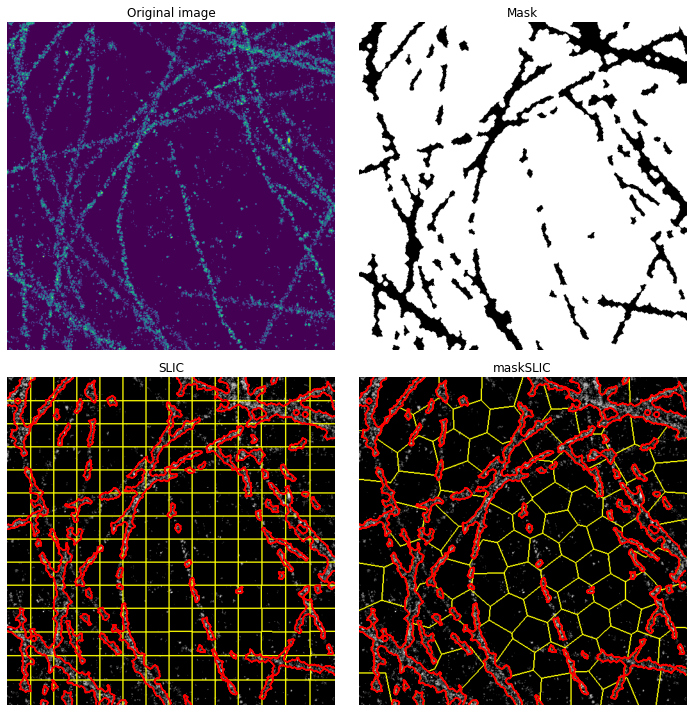

In [ ]:
# !pip install skimage
# import skimage
import matplotlib.pyplot as plt
from skimage import data, io
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
# img = data.immunohistochemistry()
img = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp/1-m.png", as_gray=1)
# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.1, 50),
    50)

mask = morphology.opening(mask, morphology.disk(4))

# SLIC result
slic = segmentation.slic(img, n_segments=200, start_label=1)

# maskSLIC result
m_slic = segmentation.slic(img, n_segments=100, mask=mask, start_label=1)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img, m_slic))
ax4.contour(mask, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# vesicles

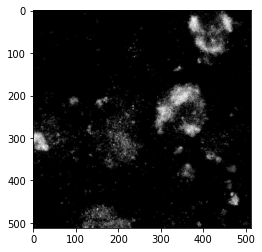

In [ ]:
import skimage
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.io import imread

im = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/test_workdir_exp1/test/example_adipocytes.png", as_gray=1)
ves = img_as_ubyte(im)
fig, ax = plt.subplots()
ax.imshow(ves, cmap=plt.cm.gray)

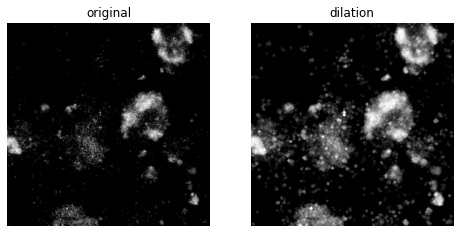

In [ ]:
multi_dilated = multi_dil(ves, 3, disk(1))
plot_comparison(ves, multi_dilated, 'dilation')

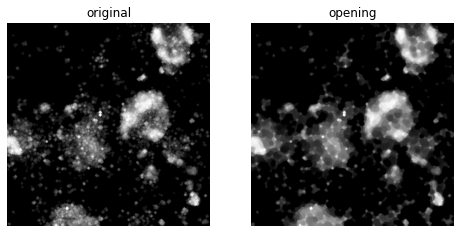

In [ ]:
closed = closing(multi_dilated, disk(5))
plot_comparison(multi_dilated, closed, 'opening')

In [ ]:
cv2.imwrite("ves-5x5-closing-disk5.png", binarize(closed))

True

In [ ]:
# bin = binarize(closed)
# rem_small = morphology.remove_small_objects(label(closed), 5)
# plot_comparison(bin, rem_small, 'dilation')

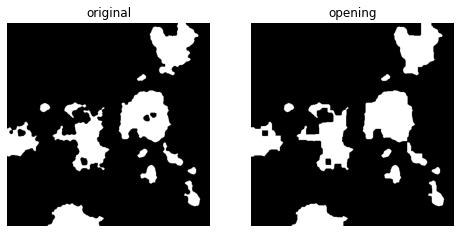

In [ ]:
import cv2

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('1.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (3,3), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

thresh = binarize(closed)

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 200:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plot_comparison(thresh, close, 'opening')

# cv2_imshow('thresh', thresh)
# cv2_imshow('close', close)
# cv2.waitKey()

In [ ]:
cv2.imwrite("ves-5x5-closing-rem-small.png", close)

True

# mask combinations

In [39]:
%%capture
%cd /content/drive/MyDrive/ANNA-PALM/segmentation_image_augmentation
!pip install -r requirements.txt

from utils import *

import skimage, random, math
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.io import imread
# !pip install albumentations

### read images to lists, take ith element from both, (rotate, (embed)x2)x4, flip, (rotate, (embed)x2)x4.

In [40]:
images_path, masks_path = get_img_mask_list('/content/drive/MyDrive/ANNA-PALM/mask-comp/MT')
images_path2, masks_path2 = get_img_mask_list('/content/drive/MyDrive/ANNA-PALM/mask-comp/VES')

images_mt = [read(f) for f in images_path]
# masks_mt = [read(f) for f in masks_path]
images_ves = [read(f) for f in images_path2]
# masks_ves = [read(f) for f in masks_path2]

masks_ves = [color_mask((skimage.color.gray2rgb(mask)), [0, 255, 255]) 
                          for mask in (read(f) for f in masks_path2)]
masks_mt = [color_mask((skimage.color.gray2rgb(mask)), [128, 255, 0]) 
                          for mask in (read(f) for f in masks_path)]

In [ ]:
for i, mt_im in enumerate(images_mt):
  for j, ves_im in enumerate(images_ves):
    
  

## segmentation_image_augmentation

In [ ]:
# %cd /content/drive/MyDrive/ANNA-PALM/mask-comp
%%capture
# %cd /content
# !git clone https://github.com/NesterukSergey/segmentation_image_augmentation
%cd /content/drive/MyDrive/ANNA-PALM/segmentation_image_augmentation
!pip install -r requirements.txt

import skimage
from utils import *
from augment.MultiPartAugmentor import MultiPartAugmentor
from augment.SemanticAugmentor import SemanticAugmentor
from augment.SingleAugmentor import SingleAugmentor

In [ ]:
def rotate_pair(img, mask, degree):
    """Rotates image and mask for the degree from range [-degree, degree]
    Args:
        img (numpy.array): RGB or grayscale image.
        mask (numpy.array): image mask.
        degree (int): maximum rotation degree.
    Returns:
        img (numpy.array): rotated image.
        mask (numpy.array): rotated image mask.
    """
    rotation_degree = int(random.random() * degree)
    rotation_degree = rotation_degree if random.random() < 0.5 else -rotation_degree

    img = rotate(img, rotation_degree)
    mask = rotate(mask, rotation_degree)

    return img, mask

def rotate(img, degree):
    """Rotates image for the specified degree.
    Args:
        img (numpy.array): RGB or grayscale image.
        degree (int): rotation degree
    Returns:
        img (numpy.array): rotated image.
    """
    pil_img = np2pil(img)
    pil_img = pil_img.rotate(degree)
    np_img = pil2np(pil_img)

    return np_img

def flip_pair(img, mask, p=1.0):
    """Flips image and mask horizontally with probability p.
    Args:
        img (numpy.array): RGB or grayscale image.
        mask (numpy.array): object image.
        p (float): probability of flipping.
    Returns:
        img (numpy.array): flipped image.
        mask (numpy.array): flipped object image.
    """
    if random.random() < p:
        img = flip(img)
        mask = flip(mask)

    return img, mask

def flip(img, p=1.0):
    """Flips image horizontally.
    Args:
        img (numpy.array): RGB or grayscale image.
        p (float): probability of flipping.
    Returns:
        img (numpy.array): flipped image.
    """
    if random.random() < p:
        if len(img.shape) == 3:
            return img[:, ::-1, :]
        else:
            return img[:, ::-1]
    else:
        return img

def embed_pair(img_top, mask_top, img_bottom, mask_bottom):

    m_top = (mask_top[:, :, 0] > 0) | (mask_top[:, :, 1] > 0) | (mask_top[:, :, 2] > 0)

    res = skimage.util.img_as_uint(img_bottom.copy())
    mask_comb = mask_bottom.copy()

    # copy the pixels from under the mask of the top image to bottom image
    res[m_top] = skimage.util.img_as_uint(img_top[m_top])
    mask_comb[m_top] = mask_top[m_top]

    return res, mask_comb

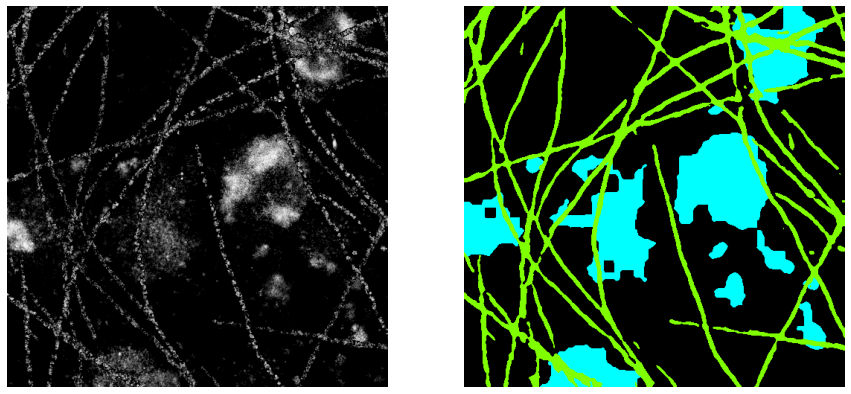

In [ ]:
a, b = embed_pair(images_mt[0], masks_mt[0], images_ves[0], masks_ves[0])
plot_comparison(a ,b)

In [ ]:
# m = (masks_ves[0][:, :, 0] > 0) | (masks_ves[0][:, :, 1] > 0) | (masks_ves[0][:, :, 2] > 0)
im= images_mt[0]
im2 = images_ves[0]
# im[m] = im2[m]

# from skimage import img_as_ubyte

img = skimage.img_as_uint(images_mt[0])

In [ ]:
print(skimage.img_as_uint(im))

[[    0  7710 13878 ...     0     0     0]
 [    0 13878 18761 ...     0     0     0]
 [    0     0  7710 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


In [ ]:
print(im2)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


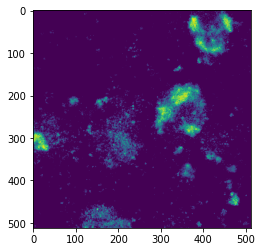

In [ ]:
plt.imshow(skimage.img_as_ubyte(im2))

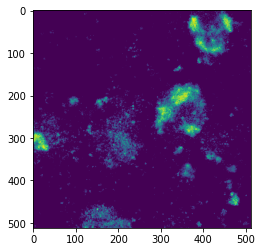

In [ ]:
plt.imshow(im2)

In [ ]:
def embed_pair(img, mask, back, small_masks_list, main_masks_list, added_width=0, start_coords=None):
    h, w = start_coords
    width_start = math.floor(added_width / 2)

    m = (mask[:, :, 0] > 0) | (mask[:, :, 1] > 0) | (mask[:, :, 2] > 0)

    b = back.copy()
    b[h:h + img.shape[0], w + width_start:w + img.shape[1] + width_start, :][m] = img[m]

    for mask_type in main_masks_list:
        main_masks_list[mask_type][h:h + img.shape[0], w + width_start:w + img.shape[1] + width_start, :][m] = \
        small_masks_list[mask_type][m]

    return b, main_masks_list

In [ ]:
# back = np.zeros((512, 512))
# skimage.io.imsave('/content/drive/MyDrive/ANNA-PALM/mask-comp/background/back.png', back)

In [ ]:
images_path, masks_path = get_img_mask_list('/content/drive/MyDrive/ANNA-PALM/mask-comp/images')
# masks_path = get_img_mask_list()
background_path = get_images_list('/content/drive/MyDrive/ANNA-PALM/mask-comp/background/')

In [ ]:
images = [read(f) for f in images_path]
masks = [read(f) for f in masks_path]
background = [read(f) for f in background_path]

In [ ]:
masks_3ch = [skimage.color.gray2rgb(mask) for mask in masks]
im_3ch = [skimage.color.gray2rgb(im) for im in images]
sinle_chan_masks = [color_mask(mask, [255, 255, 255]) for mask in masks_3ch]

In [ ]:
# sina = SingleAugmentor({
#     'output_type_list': ['class'],
#     'overlap_ratio': 0.0,
#     'persp_trans': 0,
#     'max_rotate_degree': 30,
#     'flip_prob': 0.5,
#     'background': 'img',
#     'background_image_list': background,
#     'salt': 0,
#     'pepper': 0,
#     'gauss_var': 0,
#     'smooth_kernel_size': 1,
#     'bboxes': False,
#     'num_classes': 2
# })

# single_transformed = sina.transform(im_3ch, sinle_chan_masks, class_list=[0,1])
# show_transforms(single_transformed)